# Template background model production with Gammapy

## Introduction 

In this tutorial, we will <span class="mark">create a template background model</span> in the `bkg_2d` format, i.e. with offset and energy axes (see [spec](http://gamma-astro-data-formats.readthedocs.io/en/latest/irfs/background/index.html#bkg-2d-format)) and <span class="mark">make a HDU index table</span>.

We will be working with only 4 H.E.S.S. runs on the Crab nebula here, just as an example.

To build a coherent background model you normally use 100s of runs of AGN observations or intentional "off" runs that point at parts of the sky containing no known gamma-ray sources.

We will mainly be using the following classes:
        
* [gammapy.data.DataStore](http://docs.gammapy.org/en/latest/api/gammapy.data.DataStore.html) to load the runs to use to build the bkg model.
* [gammapy.data.ObservationGroupAxis](http://docs.gammapy.org/en/latest/api/gammapy.data.ObservationGroupAxis.html) and [gammapy.data.ObservationGroups](http://docs.gammapy.org/en/latest/api/gammapy.data.ObservationGroups.html) to group the runs
* [gammapy.background.OffDataBackgroundMaker](http://docs.gammapy.org/en/latest/api/gammapy.background.OffDataBackgroundMaker.html) to compute the background model
* [gammapy.background.EnergyOffsetBackgroundModel](http://docs.gammapy.org/en/latest/api/gammapy.background.EnergyOffsetBackgroundModel.html) to represent and write the background model



## Setup

As always, we start the notebook with some setup and imports.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import shutil
import numpy as np
import astropy.units as u
from astropy.table import Table
from astropy.coordinates import SkyCoord, Angle

In [3]:
from gammapy.extern.pathlib import Path
from gammapy.utils.energy import EnergyBounds
from gammapy.utils.nddata import sqrt_space
from gammapy.data import DataStore, ObservationGroupAxis, ObservationGroups
from gammapy.background import EnergyOffsetBackgroundModel
from gammapy.background import OffDataBackgroundMaker
from gammapy.catalog import SourceCatalogGammaCat

## Compute background model

Computing a set of template background model has two major steps:
1. Define group of runs for each background model
2. Run the `OffDataBackgroundMaker`

We also need a scratch directory, and a table of known gamma-ray sources to exclude.

### Make a scratch directory

Background model production is a little pipeline that needs a "scratch" directory to put some files while running. Let's make ourselves a fresh empty scratch sub-directory called `background` in the current working directory.

In [4]:
def make_fresh_dir(path):
    """Make a fresh directory. Delete first if exists"""    
    path = Path(path)
    if path.is_dir():
        shutil.rmtree(str(path))
    path.mkdir()
    return path

In [5]:
scratch_dir = make_fresh_dir('background')
scratch_dir

PosixPath('background')

### Make an observation table defining the run grouping

Prepare a scheme to group observations with similar observing conditions and create a new ObservationTable with the grouping ID for each run

In [6]:
# Create a background model from the 4 Crab runs for the counts ouside the exclusion region so here outside the Crab
data_store = DataStore.from_dir("$GAMMAPY_EXTRA/datasets/hess-crab4-hd-hap-prod2")

In [7]:
data_store.obs_table

ALT_PNT,AZ_PNT,DEADC,DEC_OBJ,DEC_PNT,EVENT_COUNT,EVENT_DEC_MEDIAN,EVENT_ENERGY_MEDIAN,EVENT_RA_MEDIAN,EVENT_TIME_MAX,EVENT_TIME_MIN,LIVETIME,MUONEFF,N_TELS,OBJECT,OBS_ID,ONTIME,QUALITY,RA_OBJ,RA_PNT,TELLIST,TSTART,TSTART_STR,TSTOP,TSTOP_STR,ZEN_PNT
float32,float32,float32,float32,float32,int64,float32,float32,float32,float64,float64,float32,float32,int64,str11,int64,float32,int64,float32,float32,str7,float32,str19,float32,str19,float32
40.6062,26.5339,0.937603,22.0144,21.5144,7613,21.526,0.952794,83.6066,155471662.006,155469975.668,1581.74,0.927107,4,Crab Nebula,23523,1687.0,0,83.6333,83.6333,"1,2,3,4",53343.9,2004-12-04 22:05:10,53343.9,2004-12-04 22:33:17,49.3938
43.2123,12.5513,0.934454,22.0144,22.5144,7581,22.3585,0.836354,83.6332,155474412.69,155472730.323,1572.69,0.931116,4,Crab Nebula,23526,1683.0,0,83.6333,83.6333,"1,2,3,4",53344.0,2004-12-04 22:51:04,53344.0,2004-12-04 23:19:07,46.7877
44.2392,8.70994,0.936016,22.0144,22.0144,7601,21.9768,0.793617,85.1787,155647886.125,155646200.625,1578.12,0.942401,4,Crab Nebula,23559,1686.0,0,83.6333,85.2533,"1,2,3,4",53346.0,2004-12-06 23:02:15,53346.0,2004-12-06 23:30:21,45.7608
41.0344,23.7368,0.937879,22.0144,22.0144,7334,21.9517,0.941886,82.1431,155816471.685,155814785.825,1581.26,0.916893,4,Crab Nebula,23592,1686.0,0,83.6333,82.0133,"1,2,3,4",53347.9,2004-12-08 21:52:00,53347.9,2004-12-08 22:20:06,48.9656


In [8]:
# Define the grouping you want to use to group the obervations to make the acceptance curves
# Here we use 2 Zenith angle bins only, you can also add efficiency bins for example etc...
axes = [ObservationGroupAxis('ZEN_PNT', [0, 49, 90], fmt='edges')]

# Create the ObservationGroups object
obs_groups = ObservationGroups(axes)

In [9]:
# Write it to file --> we will need it later in order to create HDU index table
filename = str(scratch_dir / 'group-def.fits')
obs_groups.obs_groups_table.write(filename, overwrite=True)

In [10]:
# Create a new ObservationTable with the column group_id
# You give the runs list you want to use to produce the background model that are in your obs table. 
# Here very simple only the 4 Crab runs...
list_ids = [23523, 23526, 23559, 23592]
obs_table_with_group_id = obs_groups.apply(data_store.obs_table.select_obs_id(list_ids))

In [11]:
obs_table_with_group_id

GROUP_ID,ALT_PNT,AZ_PNT,DEADC,DEC_OBJ,DEC_PNT,EVENT_COUNT,EVENT_DEC_MEDIAN,EVENT_ENERGY_MEDIAN,EVENT_RA_MEDIAN,EVENT_TIME_MAX,EVENT_TIME_MIN,LIVETIME,MUONEFF,N_TELS,OBJECT,OBS_ID,ONTIME,QUALITY,RA_OBJ,RA_PNT,TELLIST,TSTART,TSTART_STR,TSTOP,TSTOP_STR,ZEN_PNT
int64,float32,float32,float32,float32,float32,int64,float32,float32,float32,float64,float64,float32,float32,int64,str11,int64,float32,int64,float32,float32,str7,float32,str19,float32,str19,float32
0,43.2123,12.5513,0.934454,22.0144,22.5144,7581,22.3585,0.836354,83.6332,155474412.69,155472730.323,1572.69,0.931116,4,Crab Nebula,23526,1683.0,0,83.6333,83.6333,"1,2,3,4",53344.0,2004-12-04 22:51:04,53344.0,2004-12-04 23:19:07,46.7877
0,44.2392,8.70994,0.936016,22.0144,22.0144,7601,21.9768,0.793617,85.1787,155647886.125,155646200.625,1578.12,0.942401,4,Crab Nebula,23559,1686.0,0,83.6333,85.2533,"1,2,3,4",53346.0,2004-12-06 23:02:15,53346.0,2004-12-06 23:30:21,45.7608
0,41.0344,23.7368,0.937879,22.0144,22.0144,7334,21.9517,0.941886,82.1431,155816471.685,155814785.825,1581.26,0.916893,4,Crab Nebula,23592,1686.0,0,83.6333,82.0133,"1,2,3,4",53347.9,2004-12-08 21:52:00,53347.9,2004-12-08 22:20:06,48.9656
1,40.6062,26.5339,0.937603,22.0144,21.5144,7613,21.526,0.952794,83.6066,155471662.006,155469975.668,1581.74,0.927107,4,Crab Nebula,23523,1687.0,0,83.6333,83.6333,"1,2,3,4",53343.9,2004-12-04 22:05:10,53343.9,2004-12-04 22:33:17,49.3938


### Make table of known gamma-ray sources to exclude

We need a maskto remove known sources from the observation. We use SourceCatalogGammaCat and exclude a circular region of at least 0.3° radius. Here since we use Crab runs, we will remove the Crab events from the FOV to select only the OFF events to build the acceptance curves. Of course normally you use thousand of AGN runs to build coherent acceptance curves.

In [12]:
cat = SourceCatalogGammaCat()

In [13]:
cat.table

source_id,common_name,gamma_names,fermi_names,other_names,where,classes,discoverer,seen_by,discovery_date,tevcat_id,tevcat2_id,tevcat_name,tgevcat_id,tgevcat_name,reference_id,significance,livetime,ra,dec,glon,glat,pos_ra,pos_dec,pos_glon,pos_glat,pos_err,morph_type,morph_sigma,morph_sigma_err,morph_sigma2,morph_sigma2_err,morph_pa,morph_pa_err,morph_pa_frame,spec_type,spec_pl_norm,spec_pl_norm_err,spec_pl_norm_err_sys,spec_pl_index,spec_pl_index_err,spec_pl_index_err_sys,spec_pl_e_ref,spec_pl2_flux,spec_pl2_flux_err,spec_pl2_flux_err_sys,spec_pl2_index,spec_pl2_index_err,spec_pl2_index_err_sys,spec_pl2_e_min,spec_pl2_e_max,spec_ecpl_norm,spec_ecpl_norm_err,spec_ecpl_norm_err_sys,spec_ecpl_index,spec_ecpl_index_err,spec_ecpl_index_err_sys,spec_ecpl_e_cut,spec_ecpl_e_cut_err,spec_ecpl_e_cut_err_sys,spec_ecpl_e_ref,spec_erange_min,spec_erange_max,spec_theta,spec_dnde_1TeV,spec_dnde_1TeV_err,spec_flux_1TeV,spec_flux_1TeV_err,spec_flux_1TeV_crab,spec_flux_1TeV_crab_err,spec_eflux_1TeV_10TeV,spec_eflux_1TeV_10TeV_err,sed_reference_id,sed_n_points,sed_n_ul,sed_e_ref [40],sed_e_min [40],sed_e_max [40],sed_dnde [40],sed_dnde_err [40],sed_dnde_errp [40],sed_dnde_errn [40],sed_dnde_ul [40]
,,,,,,,,,,,,,,,,,h,deg,deg,deg,deg,deg,deg,deg,deg,deg,,deg,deg,deg,deg,deg,deg,,,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),,,,TeV,1 / (cm2 s),1 / (cm2 s),1 / (cm2 s),,,,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),,,,TeV,TeV,TeV,TeV,TeV,TeV,deg,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s),1 / (cm2 s),,,erg / (cm2 s),erg / (cm2 s),,,,TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV)
int32,str21,str76,str72,str73,str4,str11,str8,str37,str7,int64,str6,str14,int64,str14,str19,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str5,float32,float32,float32,float32,float32,float32,str8,str4,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str19,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32
1,CTA 1,VER J0006+729,,SNR G119.5+10.2,gal,"pwn,snr",veritas,veritas,2011-10,227,rC5JCj,TeV J0006+729,1,TeV J0006+7259,2013ApJ...764...38A,7.5,41.25,1.65,72.783,119.58,10.2037,1.60833,72.9836,119.604,10.4033,0.06,gauss,0.3,0.03,0.24,0.03,17.4,15.8,radec,pl,9.1e-14,1.3e-14,1.7e-14,2.2,0.2,0.3,3.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.02025e-12,2.67388e-13,8.50211e-13,1.29565e-13,4.0985,0.624576,3.01623e-12,4.31419e-13,2013ApJ...764...38A,6,0,nan .. nan,0.56 .. nan,1.0 .. nan,1.9e-12 .. nan,9e-13 .. nan,nan .. nan,nan .. nan,nan .. nan
2,SHBL J001355.9-185406,,,,egal,hbl,hess,hess,2010-11,213,70hRXZ,TeV J0013-188,2,TeV J0013-1853,,nan,nan,3.48356,-18.9018,74.632,-78.0869,nan,nan,nan,nan,nan,none,nan,nan,nan,nan,nan,nan,,none,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,2013A&A...554A..72H,3,0,0.4452 .. nan,nan .. nan,nan .. nan,1.907e-12 .. nan,nan .. nan,4.16499e-13 .. nan,4.16499e-13 .. nan,nan .. nan
3,Tycho SNR,VER J0025+641,,"SNR G120.1+1.4,3C10,SN1572",gal,snr,veritas,veritas,2010-05,209,xCyAjF,TeV J0025+641,3,TeV J0025+6410,2017ApJ...836...23A,6.9,147.0,6.3397,64.1408,120.092,1.41293,6.34,64.13,120.091,1.40217,0.0244949,point,nan,nan,nan,nan,nan,nan,,pl,2.2e-13,5e-14,6e-14,2.92,0.42,0.2,1.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,2.2e-13,5e-14,1.14583e-13,3.61445e-14,0.552357,0.174237,3.37067e-13,1.33499e-13,2017ApJ...836...23A,5,1,0.5242 .. nan,nan .. nan,nan .. nan,1.83e-12 .. nan,6.48e-13 .. nan,nan .. nan,nan .. nan,nan .. nan
4,KUV 00311-1938,,,,egal,hbl,hess,hess,2012-07,239,PKJZqs,TeV J0033-193,4,TeV J0033-1921,,nan

In [14]:
exclusion_table = cat.table.copy()
exclusion_table.rename_column('ra', 'RA')    # needs column RA
exclusion_table.rename_column('dec', 'DEC')  # needs column DEC
radius = exclusion_table['morph_sigma'].data
radius[np.isnan(radius)] = 0.3
exclusion_table['Radius'] = radius * u.deg   # needs column Radius
exclusion_table = Table(exclusion_table)

In [15]:
exclusion_table[np.where(exclusion_table['Radius']<0.3)]

source_id,common_name,gamma_names,fermi_names,other_names,where,classes,discoverer,seen_by,discovery_date,tevcat_id,tevcat2_id,tevcat_name,tgevcat_id,tgevcat_name,reference_id,significance,livetime,RA,DEC,glon,glat,pos_ra,pos_dec,pos_glon,pos_glat,pos_err,morph_type,morph_sigma,morph_sigma_err,morph_sigma2,morph_sigma2_err,morph_pa,morph_pa_err,morph_pa_frame,spec_type,spec_pl_norm,spec_pl_norm_err,spec_pl_norm_err_sys,spec_pl_index,spec_pl_index_err,spec_pl_index_err_sys,spec_pl_e_ref,spec_pl2_flux,spec_pl2_flux_err,spec_pl2_flux_err_sys,spec_pl2_index,spec_pl2_index_err,spec_pl2_index_err_sys,spec_pl2_e_min,spec_pl2_e_max,spec_ecpl_norm,spec_ecpl_norm_err,spec_ecpl_norm_err_sys,spec_ecpl_index,spec_ecpl_index_err,spec_ecpl_index_err_sys,spec_ecpl_e_cut,spec_ecpl_e_cut_err,spec_ecpl_e_cut_err_sys,spec_ecpl_e_ref,spec_erange_min,spec_erange_max,spec_theta,spec_dnde_1TeV,spec_dnde_1TeV_err,spec_flux_1TeV,spec_flux_1TeV_err,spec_flux_1TeV_crab,spec_flux_1TeV_crab_err,spec_eflux_1TeV_10TeV,spec_eflux_1TeV_10TeV_err,sed_reference_id,sed_n_points,sed_n_ul,sed_e_ref [40],sed_e_min [40],sed_e_max [40],sed_dnde [40],sed_dnde_err [40],sed_dnde_errp [40],sed_dnde_errn [40],sed_dnde_ul [40],Radius
,,,,,,,,,,,,,,,,,h,deg,deg,deg,deg,deg,deg,deg,deg,deg,,deg,deg,deg,deg,deg,deg,,,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),,,,TeV,1 / (cm2 s),1 / (cm2 s),1 / (cm2 s),,,,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),,,,TeV,TeV,TeV,TeV,TeV,TeV,deg,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s),1 / (cm2 s),,,erg / (cm2 s),erg / (cm2 s),,,,TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV),deg
int32,str21,str76,str72,str73,str4,str11,str8,str37,str7,int64,str6,str14,int64,str14,str19,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str5,float32,float32,float32,float32,float32,float32,str8,str4,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str19,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32
29,IC 443,"MAGIC 0616+223,VER J0616+223",,"3C 157,SNR 189.1+03.0",gal,snr,magic,"magic,veritas,milagro",2007-05,120,9xMcgD,TeV J0616+225,29,TeV J0616+2230,2009ApJ...698L.133A,8.3,37.9,94.5113,22.66,189.065,3.23499,94.2125,22.5031,189.073,2.91772,0.03,gauss,0.16,0.03,nan,nan,nan,nan,,pl,8.38e-13,2.1e-13,2.5e-13,2.99,0.38,0.3,1.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.317,2.0,0.235,8.38e-13,2.1e-13,4.21106e-13,1.32673e-13,2.02997,0.639561,1.21741e-12,4.61186e-13,2009ApJ...698L.133A,5,0,0.358 .. nan,nan .. nan,nan .. nan,1.64e-11 .. nan,6.27e-12 .. nan,nan .. nan,nan .. nan,nan .. nan,0.16
44,HESS J1018-589 B,HESS J1018-589 B,,PSR J1016-5857,gal,pwn,hess,hess,2010-08,260,QhYho8,TeV J1016-589,44,TeV J1016-5858,2012A&A...541A...5H,8.5,nan,154.088,-58.9534,284.079,-1.87988,154.129,-58.98,284.112,-1.89021,0.05,gauss,0.15,0.03,nan,nan,nan,nan,,pl,4.2e-13,1.1e-13,8e-14,2.9,0.4,0.2,1.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.6,nan,0.3,4.2e-13,1.1e-13,2.21053e-13,7.42801e-14,1.0656,0.358072,6.53555e-13,2.66125e-13,,0,0,nan .. nan,nan .. nan,nan .. nan,nan .. nan,nan .. nan,nan .. nan,nan .. nan,nan .. nan,0.15
46,Westerlund 2,HESS J1023-575,,"RCW 49,WR20a,PSR J1022-5746",gal,unid,hess,hess,2007-06,132,nvPEhx,TeV J1023-577,46,TeV J1023-5747,2011A&A...525A..46H,16.0,45.9,155.75,-57.5,284.016,-0.184706,155.85,-57.79,284.217,-0.40076,0.0244949,gauss,0.18,0.02,nan,nan,nan,nan,,pl,3.25e-12,5e-13,6.5e-13,2.58,0.19,0.2,1.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.8,nan,0.33,3.25e-12,5e-13,2.05696e-12,4.01658e-13,9.91573,1.93622,6.61633e-12,1.52409e-12,2011A&A...525A..46H,7,0,0.7948 .. nan,nan .. nan,nan .. nan,5.59

### Run the OffDataBackgroundMaker

Make the acceptance curves in the different group of observation conditions you defined above using the obs_table containaing the group id for each observation used to compute the bkg model

In [16]:
bgmaker = OffDataBackgroundMaker(
    data_store=data_store,
    outdir=str(scratch_dir),
    run_list=None,
    obs_table=obs_table_with_group_id,
    ntot_group=obs_groups.n_groups,
    excluded_sources=exclusion_table,  ## also needs a group_def.fits ?
)

In [17]:
# Define the energy and offset binning to use
ebounds = EnergyBounds.equal_log_spacing(0.1, 100, 15, 'TeV')
offset = sqrt_space(start=0, stop=2.5, num=100) * u.deg ## !!!

In [18]:
# Make the model (i.e. stack counts and livetime)
bgmaker.make_model("2D", ebounds=ebounds, offset=offset)

# Smooth the model
bgmaker.smooth_models("2D")

# Write the model to disk
bgmaker.save_models("2D")   ## using outdir param
bgmaker.save_models(modeltype="2D", smooth=True)

Congratulations, you have produced a background model.

The following files were generated in our scratch directory:

In [19]:
[path.name for path in scratch_dir.glob('*')]


['background_2D_group_000_table.fits.gz',
 'background_2D_group_001_table.fits.gz',
 'group-def.fits',
 'smooth_background_2D_group_000_table.fits.gz',
 'smooth_background_2D_group_001_table.fits.gz']

## Inspect the background model

Our template background model has two axes: offset and energy.

Let's make a few plots to see what it looks like:
1. Acceptance curve (background rate as a function of field of view offset for a given energy)
1. Rate spectrum (background rate as a function of energy for a given offset)
1. Rate image (background rate as a function of energy and offset)

### Acceptance curve

In [20]:
# Read one of the background models from file
filename = scratch_dir / 'smooth_background_2D_group_000_table.fits.gz'
model = EnergyOffsetBackgroundModel.read(str(filename))

(<matplotlib.axes._subplots.AxesSubplot at 0x11d5f7f98>,
 <matplotlib.colorbar.Colorbar at 0x11d806550>)

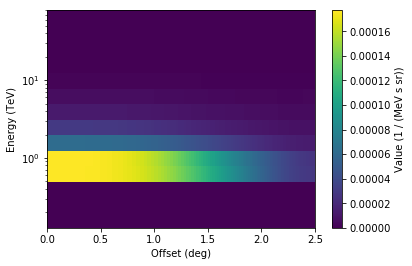

In [21]:
model.bg_rate.plot()

(<matplotlib.axes._subplots.AxesSubplot at 0x11db9af28>,
 <matplotlib.colorbar.Colorbar at 0x11dbc87b8>)

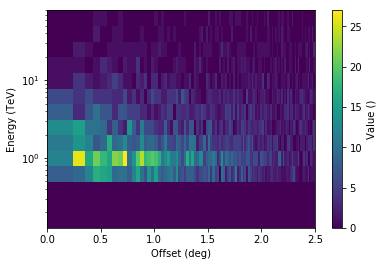

In [22]:
model.counts.plot()

In [23]:
offsets = model.bg_rate.offset_bin_center
energies = model.bg_rate.energy  

In [24]:
energies

<EnergyBounds [   0.1       ,   0.15848932,   0.25118864,   0.39810717,
                  0.63095734,   1.        ,   1.58489319,   2.51188643,
                  3.98107171,   6.30957344,  10.        ,  15.84893192,
                 25.11886432,  39.81071706,  63.09573445, 100.        ] TeV>

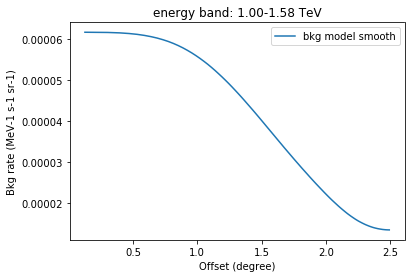

In [25]:
iE = 5 ### fith band !!!!!

x = offsets
y = model.bg_rate.data[iE,:]
plt.plot(x, y, label="bkg model smooth")
title = "energy band: "+str("%.2f"%energies[iE].value)+"-"+str("%.2f"%energies[iE+1].value)+" TeV"  
plt.title(title)
plt.xlabel("Offset (degree)")
plt.ylabel("Bkg rate (MeV-1 s-1 sr-1)")
plt.legend()

### Background rate spectrum

In [26]:
offsets.deg

array([ 0.12562973,  0.30329699,  0.39526433,  0.46885652,  0.53217606,
        0.58864534,  0.64011374,  0.68771954,  0.73222371,  0.77416526,
        0.81394275,  0.85186081,  0.88815856,  0.92302782,  0.95662524,
        0.98908075,  1.02050354,  1.05098642,  1.08060907,  1.1094405 ,
        1.13754095,  1.16496338,  1.19175466,  1.21795646,  1.24360609,
        1.26873706,  1.29337964,  1.31756124,  1.34130681,  1.36463914,
        1.38757907,  1.41014577,  1.43235689,  1.45422873,  1.47577638,
        1.49701385,  1.51795416,  1.53860944,  1.55899104,  1.57910955,
        1.59897491,  1.61859643,  1.6379829 ,  1.65714254,  1.67608316,
        1.69481209,  1.71333628,  1.73166229,  1.74979637,  1.76774441,
        1.78551202,  1.80310455,  1.82052706,  1.8377844 ,  1.85488117,
        1.87182178,  1.88861043,  1.90525113,  1.92174774,  1.93810392,
        1.95432321,  1.97040899,  1.9863645 ,  2.00219286,  2.01789705,
        2.03347997,  2.04894436,  2.0642929 ,  2.07952815,  2.09

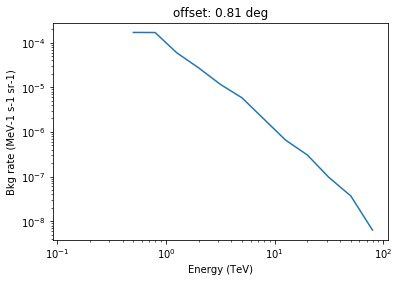

In [27]:
x = energies.log_centers
y = model.bg_rate.data[:,10]
plt.loglog(x, y, label="bkg model smooth")
plt.title("offset: "+str("%.2f"%offsets[10].value)+" deg")
plt.xlabel("Energy (TeV)")
plt.ylabel("Bkg rate (MeV-1 s-1 sr-1)")

### Background rate image with energy and offset axes

It doesn't look good in this case.
To do this well, you need to use more off or AGN runs to build the background model!

(<matplotlib.axes._subplots.AxesSubplot at 0x11db842b0>,
 <matplotlib.colorbar.Colorbar at 0x11d889f60>)

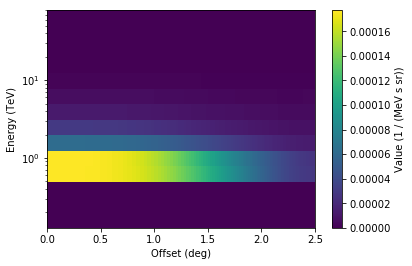

In [28]:
model.bg_rate.plot()

## Make new HDU index table including background

Here we first copy the dataset of the 4 crab runs from gammapy-extra in a new directory containing the data you will use for the analysis. 

We use the same dataset to produce the bkg or for the analysis. Of course normally you produce the bkg model using thousands of AGN runs not the 4 Crab test runs.

In [29]:
# Make a new hdu table in your dataset directory that contains the link to the acceptance curve to use to build the bkg model in your cube analysis
data_dir = make_fresh_dir('data')

In [30]:
ds = DataStore.from_dir("$GAMMAPY_EXTRA/datasets/hess-crab4-hd-hap-prod2")
ds.copy_obs(ds.obs_table, data_dir)

The hdu_table in this directory contains no link to a bkg model for each observation. 

In [31]:
data_store = DataStore.from_dir(data_dir)
data_store.hdu_table

OBS_ID,HDU_TYPE,HDU_CLASS,FILE_DIR,FILE_NAME,HDU_NAME,SIZE,MTIME,MD5
int64,str6,str10,str26,str30,str12,int64,float64,str32
23523,gti,gti,run023400-023599/run023523,hess_events_023523.fits.gz,GTI,620975,1455089616.34,9e402094c3a3e05ae4199b7cc9a01215
23523,events,events,run023400-023599/run023523,hess_events_023523.fits.gz,EVENTS,620975,1455089616.34,9e402094c3a3e05ae4199b7cc9a01215
23523,aeff,aeff_2d,run023400-023599/run023523,hess_aeff_2d_023523.fits.gz,AEFF_2D,3727,1455089616.34,6430c082176f092e0aed0f2bf9840915
23523,edisp,edisp_2d,run023400-023599/run023523,hess_edisp_2d_023523.fits.gz,EDISP_2D,28963,1455089616.34,f580ea6cb104e4d6735b8d2940ac6774
23523,psf,psf_3gauss,run023400-023599/run023523,hess_psf_3gauss_023523.fits.gz,PSF_2D_GAUSS,3027,1455089616.34,87f2d5c5ca56575a4a083b33e9700312
23523,psf,psf_king,run023400-023599/run023523,hess_psf_king_023523.fits.gz,PSF_2D_KING,1823,1455089616.34,7760e349a40883345406c7e3ea1cbd54
23523,psf,psf_table,run023400-023599/run023523,hess_psf_table_023523.fits.gz,PSF_2D_TABLE,221574,1455089616.35,74b745938341d0f64b79f60da7f1ad0f
23526,psf,psf_king,run023400-023599/run023526,hess_psf_king_023526.fits.gz,PSF_2D_KING,1834,1455089616.56,5873e4ec0771bdfcc6d82608199a4067
23526,psf,psf_3gauss,run023400-023599/run023526,hess_psf_3gauss_023526.fits.gz,PSF_2D_GAUSS,3002,1455089616.56,f27364b40bbf8e35c747828e60224b28


In order to produce a background image or background cube we have to create a hdu table that contains for each observation a link to the bkg model to use depending of the observation conditions of the run.

In [32]:
#Copy the background directory in the one where is located the hdu table, here data
shutil.move(str(scratch_dir), str(data_dir))

# Create the new hdu table with a link to the background model
group_filename = data_dir / 'background/group-def.fits'

#relat_path= (scratch_dir.absolute()).relative_to(data_dir.absolute())
hdu_index_table = bgmaker.make_total_index_table(
    data_store=data_store,
    modeltype='2D',
    out_dir_background_model=scratch_dir,
    filename_obs_group_table=str(group_filename),
    smooth=False,
)

# Write the new hdu table
filename = data_dir / 'hdu-index.fits.gz'
hdu_index_table.write(str(filename), overwrite=True)

In [33]:
hdu_index_table

OBS_ID,HDU_TYPE,HDU_CLASS,FILE_DIR,FILE_NAME,HDU_NAME,SIZE,MTIME,MD5
int64,str6,str10,str26,str37,str12,int64,float64,str32
23523,gti,gti,run023400-023599/run023523,hess_events_023523.fits.gz,GTI,620975,1455089616.34,9e402094c3a3e05ae4199b7cc9a01215
23523,events,events,run023400-023599/run023523,hess_events_023523.fits.gz,EVENTS,620975,1455089616.34,9e402094c3a3e05ae4199b7cc9a01215
23523,aeff,aeff_2d,run023400-023599/run023523,hess_aeff_2d_023523.fits.gz,AEFF_2D,3727,1455089616.34,6430c082176f092e0aed0f2bf9840915
23523,edisp,edisp_2d,run023400-023599/run023523,hess_edisp_2d_023523.fits.gz,EDISP_2D,28963,1455089616.34,f580ea6cb104e4d6735b8d2940ac6774
23523,psf,psf_3gauss,run023400-023599/run023523,hess_psf_3gauss_023523.fits.gz,PSF_2D_GAUSS,3027,1455089616.34,87f2d5c5ca56575a4a083b33e9700312
23523,psf,psf_king,run023400-023599/run023523,hess_psf_king_023523.fits.gz,PSF_2D_KING,1823,1455089616.34,7760e349a40883345406c7e3ea1cbd54
23523,psf,psf_table,run023400-023599/run023523,hess_psf_table_023523.fits.gz,PSF_2D_TABLE,221574,1455089616.35,74b745938341d0f64b79f60da7f1ad0f
23526,psf,psf_king,run023400-023599/run023526,hess_psf_king_023526.fits.gz,PSF_2D_KING,1834,1455089616.56,5873e4ec0771bdfcc6d82608199a4067
23526,psf,psf_3gauss,run023400-023599/run023526,hess_psf_3gauss_023526.fits.gz,PSF_2D_GAUSS,3002,1455089616.56,f27364b40bbf8e35c747828e60224b28


In [34]:
print(hdu_index_table[-4]["FILE_DIR"], " ", hdu_index_table[-4]["FILE_NAME"])

background   background_2D_group_000_table.fits.gz


In [35]:
print(hdu_index_table[-1]["FILE_DIR"], " ", hdu_index_table[-1]["FILE_NAME"])

background   background_2D_group_001_table.fits.gz


## Exercises

- Use real AGN run
- Change the binning for the grouping: thinner zenithal bin, add efficiency binning ....
- Change the energy binning (ebounds) and the offset (offset) used to compute the acceptance curve


## What next?

In this tutorial we have created a template background model in the `bkg_2d` format, i.e. with offset and energy axes (see [spec](http://gamma-astro-data-formats.readthedocs.io/en/latest/irfs/background/index.html#bkg-2d-format)).

In future tutorials, we will use this background model as one of the model components for source analysis.